## Reference code
https://github.com/NaJaeMin92/pytorch_DANN

In [1]:
from utils import *
np.random.seed(10)
torch.manual_seed(10)

In [2]:
dataset = sio.loadmat('2Moons_v2.mat')

X_,X_adapt_ = dataset['X'], dataset['X_adapt']
Y_,yt_ = dataset['Y'].squeeze()-1, (1-dataset['yt'].squeeze())/2

## Data plot

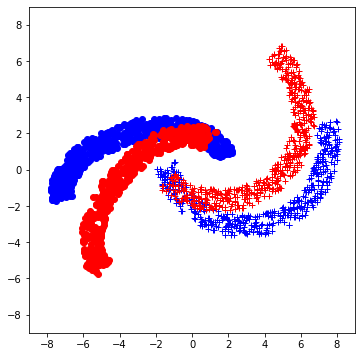

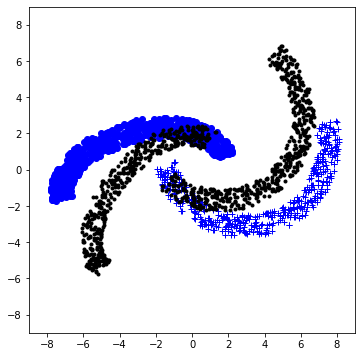

In [3]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# Source domain
# label 1
plt.plot(X_[np.where(Y_==0)[0],0],X_[np.where(Y_==0)[0],1],'bo')
# label 2
plt.plot(X_[np.where(Y_==1)[0],0],X_[np.where(Y_==1)[0],1],'b+')

# Target domain
# label 1
plt.plot(X_adapt_[np.where(yt_==0)[0],0],X_adapt_[np.where(yt_==0)[0],1],'ro')
# label 2
plt.plot(X_adapt_[np.where(yt_==1)[0],0],X_adapt_[np.where(yt_==1)[0],1],'r+')

ax.set_aspect('equal')
plt.xlim([-9,9]), plt.ylim([-9,9])
plt.savefig('./docs/dataset_labeled.png')

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
# Source domain
# label 1
plt.plot(X_[np.where(Y_==0)[0],0],X_[np.where(Y_==0)[0],1],'bo')
# label 2
plt.plot(X_[np.where(Y_==1)[0],0],X_[np.where(Y_==1)[0],1],'b+')

# Target domain
plt.plot(X_adapt_[:,0],X_adapt_[:,1],'k.')

ax.set_aspect('equal')
plt.xlim([-9,9]), plt.ylim([-9,9])
plt.savefig('./docs/dataset_unlabeled.png')
plt.show()

## Dataset

In [4]:
X = torch.tensor(X_).type(torch.float32)
X_adapt = torch.tensor(X_adapt_).type(torch.float32)
Y = torch.LongTensor(Y_)
yt = torch.LongTensor(yt_)

In [5]:
batch_size = 32

x_train_source, x_test_source, y_train_source, y_test_source = train_test_split(X,Y,test_size = 0.2) 
train_source = DataLoader(TensorDataset(x_train_source,y_train_source), batch_size=batch_size, shuffle=True)

x_train_target, x_test_target, y_train_target, y_test_target = train_test_split(X_adapt,yt,test_size = 0.2) 
train_target = DataLoader(x_train_target, batch_size=batch_size, shuffle=True)

># Source only

>### Model

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.hidden = nn.Linear(2,15)
        self.out = nn.Linear(15,2)                
        
    def forward(self, x):
        h = self.hidden(x)
        h = F.relu(h)
        y = self.out(h)
        return y

In [7]:
model = Model()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)  

>### Train

In [8]:
train_loss, train_acc = [],[]
            
num_epochs = 50
for epoch in range(num_epochs):                        
    
    model.train(True)
    running_loss = 0.0
    running_corrects = 0.0
    
    for batch_idx, (x, y) in enumerate(train_source):    
        
        x,y = Variable(x).cuda(),Variable(y).cuda()
        optimizer.zero_grad()       

        # forward                
        outputs = model(x)        
        _, preds = torch.max(outputs.data, 1)                                
        loss = criterion(outputs, y)        
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.data
        running_corrects += torch.sum(preds == y.data)          

    epoch_loss = running_loss / len(train_source.dataset)
    epoch_acc = running_corrects.cpu().numpy()/len(train_source.dataset)

    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)        
    if (epoch+1) % 10 == 0:
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)    
        print('{} Loss: {:.4f} Acc: {:.2f}%'.format('train', epoch_loss, 100*epoch_acc))

Epoch 10/50
----------
train Loss: 0.0039 Acc: 96.50%
Epoch 20/50
----------
train Loss: 0.0023 Acc: 97.88%
Epoch 30/50
----------
train Loss: 0.0016 Acc: 98.62%
Epoch 40/50
----------
train Loss: 0.0012 Acc: 99.12%
Epoch 50/50
----------
train Loss: 0.0009 Acc: 99.38%


>### Test

In [9]:
def acc_source_only(x,y):
    model.eval()
    out_tmp = model(x.cuda())
    _, preds = torch.max(out_tmp.data, 1)                                    
    running_corrects = torch.sum(preds == y.cuda().data)
    acc = running_corrects.cpu().numpy()/len(x)
    return acc
    
print('Source Accuracy:{:.2f}%'.format(100*acc_source_only(x_test_source,y_test_source)))    
print('Target Accuracy:{:.2f}%'.format(100*acc_source_only(x_test_target,y_test_target)))

Source Accuracy:99.50%
Target Accuracy:60.50%


>### Visualization

In [10]:
h = 0.01
x_range = np.arange(-9.5, 9.5, h)
xx, yy = np.meshgrid(x_range,x_range)

with torch.no_grad():
    out = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float32).to(device))    
    z = out.max(1,keepdim = True)[1].cpu().numpy()
z = z.reshape(xx.shape)

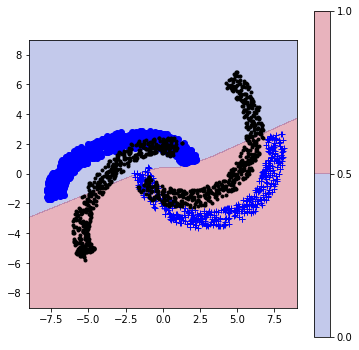

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

cntr  = plt.contourf(xx, yy, z,levels=1,alpha=0.3,cmap=plt.cm.get_cmap('coolwarm', 2))

# Source domain
# label 1
plt.plot(X_[np.where(Y_==0)[0],0],X_[np.where(Y_==0)[0],1],'bo')
# label 2
plt.plot(X_[np.where(Y_==1)[0],0],X_[np.where(Y_==1)[0],1],'b+')

# Target domain
plt.plot(X_adapt_[:,0],X_adapt_[:,1],'k.')

ax.set_aspect('equal')
plt.xlim([-9,9]), plt.ylim([-9,9])
plt.colorbar(cntr)

# for i in range(model.hidden.out_features):
#     w = model.hidden.weight[i].detach().cpu().numpy()
#     b = model.hidden.bias[i].detach().cpu().numpy()
#     y_tmp = -1/w[1]*(w[0]*x_range+b)
#     plt.plot(x_range,y_tmp,'--')

plt.savefig('./docs/result_source_only.png')
plt.show()

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.007s...
[t-SNE] Computed neighbors for 2000 samples in 0.165s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.397671
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.806175
[t-SNE] KL divergence after 1000 iterations: 0.241802


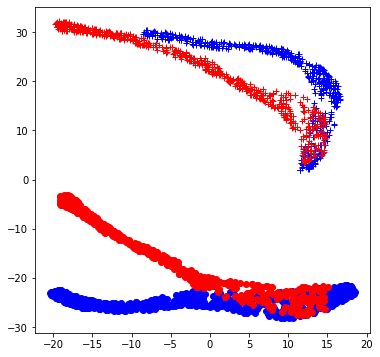

In [12]:
#====== T-SNE ======#
model_feat = model.hidden
model_feat.to('cpu')

feat_s0 = model_feat(torch.tensor(X_[np.where(Y_==0)[0],:]).type(torch.float32))
feat_s1 = model_feat(torch.tensor(X_[np.where(Y_==1)[0],:]).type(torch.float32))
feat_t0 = model_feat(torch.tensor(X_adapt_[np.where(yt_==0)[0],:]).type(torch.float32))
feat_t1 = model_feat(torch.tensor(X_adapt_[np.where(yt_==1)[0],:]).type(torch.float32))

tsne_input = torch.cat([feat_s0,feat_s1,feat_t0,feat_t1]).detach().numpy()
tsne = TSNE(n_components=2,perplexity=100,verbose = 1,random_state = 0)
tsne_fit= tsne.fit_transform(tsne_input)

tsne_s0 = tsne_fit[0:feat_s0.shape[0],:]
tsne_s1 = tsne_fit[feat_s0.shape[0]:feat_s0.shape[0]+feat_s1.shape[0],:]
tsne_t0 = tsne_fit[feat_s0.shape[0]+feat_s1.shape[0]:feat_s0.shape[0]+feat_s1.shape[0]+feat_t0.shape[0],:]
tsne_t1 = tsne_fit[feat_s0.shape[0]+feat_s1.shape[0]+feat_t0.shape[0]:,:]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.plot(tsne_s0[:,0],tsne_s0[:,1],'bo')
plt.plot(tsne_s1[:,0],tsne_s1[:,1],'b+')
plt.plot(tsne_t0[:,0],tsne_t0[:,1],'ro')
plt.plot(tsne_t1[:,0],tsne_t1[:,1],'r+')

plt.savefig('./docs/tsne_source_only.png')
plt.show()


_____
># Domain adaptation

>### Model

In [13]:
from torch.autograd import Function
class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None    

In [14]:
class DANN(nn.Module):
    def __init__(self):
        super(DANN,self).__init__()
        self.hidden = nn.Linear(2,15)
        self.hidden2 = nn.Linear(15,15)
        self.out = nn.Linear(15,2)                
        self.domain = nn.Linear(15,2)                
        
    def forward(self, x, alpha = 25):
        h = self.hidden(x)
        h = F.relu(h)
#         h = self.hidden2(h)
#         h = F.relu(h)
        y = self.out(h)
        d = self.domain(ReverseLayerF.apply(h,alpha))
        return y,d    

In [15]:
model = DANN()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4) 
scheduler = optim.lr_scheduler.MultiStepLR(optimizer,[40,400],gamma = 0.1)

>### Train

In [16]:
train_loss_c, train_loss_d = [],[]
train_loss, train_acc = [],[]
            
num_epochs = 800
for epoch in range(num_epochs):                        
    
    model.train(True)
    running_loss_c,running_loss_d,running_loss = 0.0,0.0,0.0
    running_corrects = 0.0
    
    for batch_idx, (source_data, target_data) in enumerate(zip(train_source,train_target)):    
        
        x_s,y_s = source_data
        x_s,y_s = Variable(x_s).cuda(),Variable(y_s).cuda()
        x_t = Variable(target_data).cuda()  
        
        optimizer.zero_grad()       

        # Classification
        outputs,_ = model(x_s)        
        _, preds = torch.max(outputs.data, 1)                                
        loss_c = criterion(outputs, y_s)        
        
        # Domain
        label_s = torch.zeros(x_s.shape[0]).type(torch.LongTensor).cuda()        
        _,out_domain = model(x_s)        
        loss_s = criterion(out_domain, label_s)        
        label_t = torch.ones(x_t.shape[0]).type(torch.LongTensor).cuda()        
        _,out_domain = model(x_t)        
        loss_t = criterion(out_domain, label_t)        
        loss_d = loss_s + loss_t
        
        loss = loss_c + loss_d
        
        loss.backward()
        optimizer.step()

        # statistics
        running_loss_c += loss_c.data
        running_loss_d += loss_d.data
        running_loss += loss.data
        running_corrects += torch.sum(preds == y_s.data)          
    
    scheduler.step()
    epoch_loss_c = running_loss_c / len(train_source.dataset)
    epoch_loss_d = running_loss_d / len(train_source.dataset)
    epoch_loss = running_loss / len(train_source.dataset)
    epoch_acc = running_corrects.cpu().numpy()/len(train_source.dataset)

    train_loss_c.append(epoch_loss_c)
    train_loss_d.append(epoch_loss_d)
    train_loss.append(epoch_loss)
    train_acc.append(epoch_acc)        
    if (epoch+1) % 20 == 0:
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)    
        print('{} Total Loss: {:.4f} Acc: {:.2f}%'.format('train', epoch_loss, 100*epoch_acc))
        print('Classification Loss: {:.4f} Domain Loss: {:.4f}'.format(epoch_loss_c, epoch_loss_d))

Epoch 20/800
----------
train Total Loss: 0.0639 Acc: 79.88%
Classification Loss: 0.0158 Domain Loss: 0.0481
Epoch 40/800
----------
train Total Loss: 0.0567 Acc: 83.50%
Classification Loss: 0.0118 Domain Loss: 0.0449
Epoch 60/800
----------
train Total Loss: 0.0561 Acc: 83.88%
Classification Loss: 0.0115 Domain Loss: 0.0446
Epoch 80/800
----------
train Total Loss: 0.0556 Acc: 84.50%
Classification Loss: 0.0112 Domain Loss: 0.0444
Epoch 100/800
----------
train Total Loss: 0.0551 Acc: 84.88%
Classification Loss: 0.0109 Domain Loss: 0.0442
Epoch 120/800
----------
train Total Loss: 0.0547 Acc: 85.12%
Classification Loss: 0.0106 Domain Loss: 0.0441
Epoch 140/800
----------
train Total Loss: 0.0543 Acc: 85.25%
Classification Loss: 0.0103 Domain Loss: 0.0440
Epoch 160/800
----------
train Total Loss: 0.0539 Acc: 85.62%
Classification Loss: 0.0101 Domain Loss: 0.0438
Epoch 180/800
----------
train Total Loss: 0.0536 Acc: 85.62%
Classification Loss: 0.0098 Domain Loss: 0.0438
Epoch 200/800


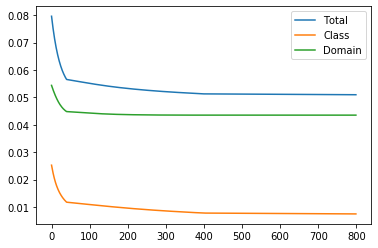

In [17]:
plt.plot(torch.stack(train_loss).cpu().numpy())
plt.plot(torch.stack(train_loss_c).cpu().numpy())
plt.plot(torch.stack(train_loss_d).cpu().numpy())
plt.legend(['Total','Class','Domain'])

>### Test

In [18]:
def acc_dann(x,y):
    model.eval()
    out_tmp,_ = model(x.cuda())
    _, preds = torch.max(out_tmp.data, 1)                                    
    running_corrects = torch.sum(preds == y.cuda().data)
    acc = running_corrects.cpu().numpy()/len(x)
    return acc

def acc_dann_domain_tmp(x,domain):
    model.eval()
    _,out_tmp = model(x.cuda())
    _, preds = torch.max(out_tmp.data, 1)                                    
    if domain == 'source':        
        running_corrects = torch.sum(preds == torch.zeros(x.shape[0]).type(torch.LongTensor).cuda())
    if domain == 'target':        
        running_corrects = torch.sum(preds == torch.ones(x.shape[0]).type(torch.LongTensor).cuda())
    acc_tmp = running_corrects.cpu().numpy()
    return acc_tmp

domain_acc_tmp = acc_dann_domain_tmp(x_test_source,'source')+acc_dann_domain_tmp(x_test_target,'target')

print('Source Accuracy:{:.2f}%'.format(100*acc_dann(x_test_source,y_test_source))) 
print('Target Accuracy:{:.2f}%'.format(100*acc_dann(x_test_target,y_test_target)))
print('-'*10)
print('Domain Accuracy:{:.2f}%'.format(100*domain_acc_tmp/(len(x_test_source)+len(x_test_target))))

Source Accuracy:92.00%
Target Accuracy:89.00%
----------
Domain Accuracy:45.75%


>### Visualization

In [19]:
h = 0.01
x_range = np.arange(-9.5, 9.5, h)
xx, yy = np.meshgrid(x_range,x_range)

with torch.no_grad():
    out,_ = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float32).to(device))    
    z = out.max(1,keepdim = True)[1].cpu().numpy()
z = z.reshape(xx.shape)

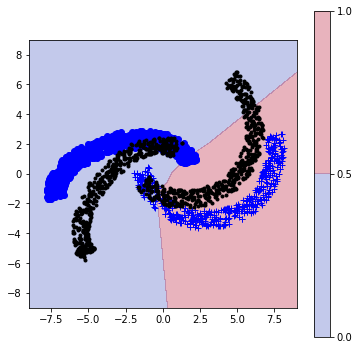

In [20]:
#===== Classification ======#
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

cntr  = plt.contourf(xx, yy, z,levels=1,alpha=0.3,cmap=plt.cm.get_cmap('coolwarm', 2))

# Source domain
# label 1
plt.plot(X_[np.where(Y_==0)[0],0],X_[np.where(Y_==0)[0],1],'bo')
# label 2
plt.plot(X_[np.where(Y_==1)[0],0],X_[np.where(Y_==1)[0],1],'b+')

# Target domain
plt.plot(X_adapt_[:,0],X_adapt_[:,1],'k.')

ax.set_aspect('equal')
plt.xlim([-9,9]), plt.ylim([-9,9])
plt.colorbar(cntr)

# for i in range(model.hidden.out_features):
#     w = model.hidden.weight[i].detach().cpu().numpy()
#     b = model.hidden.bias[i].detach().cpu().numpy()
#     y_tmp = -1/w[1]*(w[0]*x_range+b)
#     plt.plot(x_range,y_tmp,'--')

plt.savefig('./docs/result_dann.png')
plt.show()

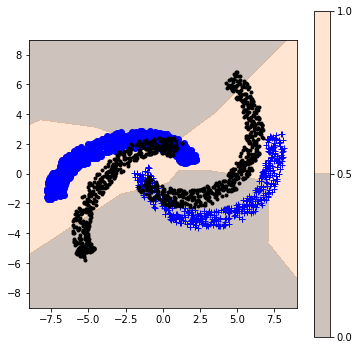

In [21]:
#====== Domain ======#
h = 0.01
x_range = np.arange(-9.5, 9.5, h)
xx, yy = np.meshgrid(x_range,x_range)

with torch.no_grad():
    _,out = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float32).to(device))    
    z = out.max(1,keepdim = True)[1].cpu().numpy()
z = z.reshape(xx.shape)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

cntr  = plt.contourf(xx, yy, z,levels=1,alpha=0.3,cmap=plt.cm.get_cmap('copper', 8))

# Source domain
# label 1
plt.plot(X_[np.where(Y_==0)[0],0],X_[np.where(Y_==0)[0],1],'bo')
# label 2
plt.plot(X_[np.where(Y_==1)[0],0],X_[np.where(Y_==1)[0],1],'b+')

# Target domain
plt.plot(X_adapt_[:,0],X_adapt_[:,1],'k.')

ax.set_aspect('equal')
plt.xlim([-9,9]), plt.ylim([-9,9])
plt.colorbar(cntr)

# for i in range(model.hidden.out_features):
#     w = model.hidden.weight[i].detach().cpu().numpy()
#     b = model.hidden.bias[i].detach().cpu().numpy()
#     y_tmp = -1/w[1]*(w[0]*x_range+b)
#     plt.plot(x_range,y_tmp,'--')

plt.savefig('./docs/result_dann_domain.png')
plt.show()

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.005s...
[t-SNE] Computed neighbors for 2000 samples in 0.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 1.172158
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.469444
[t-SNE] KL divergence after 1000 iterations: 0.236365


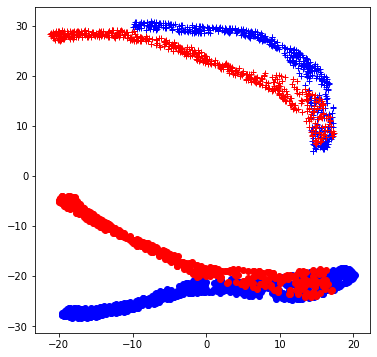

In [22]:
#====== T-SNE ======#
model_feat = model.hidden
model_feat.to('cpu')

feat_s0 = model_feat(torch.tensor(X_[np.where(Y_==0)[0],:]).type(torch.float32))
feat_s1 = model_feat(torch.tensor(X_[np.where(Y_==1)[0],:]).type(torch.float32))
feat_t0 = model_feat(torch.tensor(X_adapt_[np.where(yt_==0)[0],:]).type(torch.float32))
feat_t1 = model_feat(torch.tensor(X_adapt_[np.where(yt_==1)[0],:]).type(torch.float32))

tsne_input = torch.cat([feat_s0,feat_s1,feat_t0,feat_t1]).detach().numpy()
tsne = TSNE(n_components=2,perplexity=100,verbose = 1,random_state = 0)
tsne_fit= tsne.fit_transform(tsne_input)

tsne_s0 = tsne_fit[0:feat_s0.shape[0],:]
tsne_s1 = tsne_fit[feat_s0.shape[0]:feat_s0.shape[0]+feat_s1.shape[0],:]
tsne_t0 = tsne_fit[feat_s0.shape[0]+feat_s1.shape[0]:feat_s0.shape[0]+feat_s1.shape[0]+feat_t0.shape[0],:]
tsne_t1 = tsne_fit[feat_s0.shape[0]+feat_s1.shape[0]+feat_t0.shape[0]:,:]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
plt.plot(tsne_s0[:,0],tsne_s0[:,1],'bo')
plt.plot(tsne_s1[:,0],tsne_s1[:,1],'b+')
plt.plot(tsne_t0[:,0],tsne_t0[:,1],'ro')
plt.plot(tsne_t1[:,0],tsne_t1[:,1],'r+')

plt.savefig('./docs/tsne_dann.png')
plt.show()